In [ ]:
# Python ≥3.5 is required
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

# to make this notebook's output reproducable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
import tensorflow_datasets as tfds #If "import tensorflow_datasets as tfds" does not work, run: conda install -c anaconda tensorflow-datasets
(train_set_raw, valid_set_raw, test_set_raw), info = tfds.load("tf_flowers",split=["train[:80%]","train[80%:90%]","train[90%:]"], as_supervised= True, with_info=True)

In [ ]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [ ]:
info.splits['train']

<tfds.core.SplitInfo num_examples=3670>

In [ ]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes = info.features["label"].num_classes
n_classes

5

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

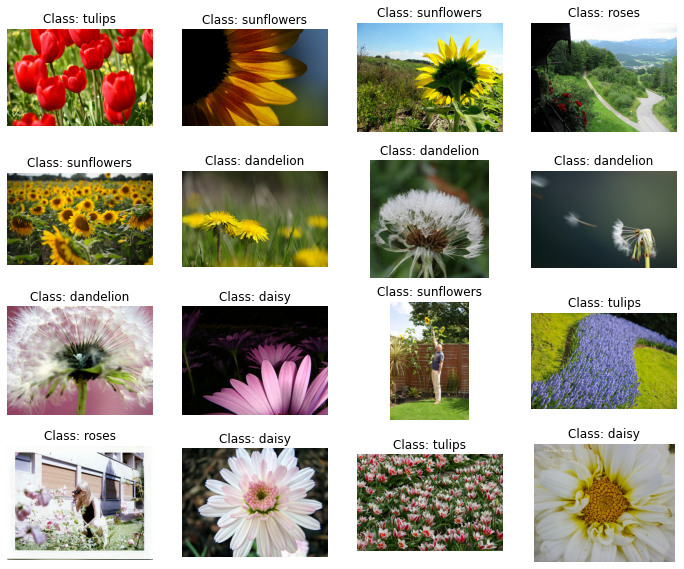

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(16):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [ ]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
#train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
#print the layers
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [ ]:
# Freeze the base layers weight
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.80 * dataset_size / batch_size), 
                    validation_data=valid_set, 
                    validation_steps=int(0.10 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
91/91 [==============================] - 40s 369ms/step - loss: 1.3638 - accuracy: 0.7957 - val_loss: 0.7792 - val_accuracy: 0.8750
Epoch 2/5
91/91 [==============================] - 33s 358ms/step - loss: 0.5643 - accuracy: 0.9011 - val_loss: 0.5810 - val_accuracy: 0.8835
Epoch 3/5
91/91 [==============================] - 32s 357ms/step - loss: 0.2466 - accuracy: 0.9378 - val_loss: 0.4684 - val_accuracy: 0.8835
Epoch 4/5
91/91 [==============================] - 32s 358ms/step - loss: 0.1237 - accuracy: 0.9605 - val_loss: 0.3940 - val_accuracy: 0.9062
Epoch 5/5
91/91 [==============================] - 33s 358ms/step - loss: 0.0870 - accuracy: 0.9742 - val_loss: 0.4342 - val_accuracy: 0.8977


In [ ]:
#unfreeze the base layers
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.80 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.10 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
91/91 [==============================] - 133s 1s/step - loss: 0.3408 - accuracy: 0.8843 - val_loss: 0.4941 - val_accuracy: 0.8835
Epoch 2/40
91/91 [==============================] - 124s 1s/step - loss: 0.0649 - accuracy: 0.9791 - val_loss: 0.3180 - val_accuracy: 0.9347
Epoch 3/40
91/91 [==============================] - 124s 1s/step - loss: 0.0264 - accuracy: 0.9924 - val_loss: 0.3081 - val_accuracy: 0.9233
Epoch 4/40
91/91 [==============================] - 124s 1s/step - loss: 0.0153 - accuracy: 0.9955 - val_loss: 0.2817 - val_accuracy: 0.9318
Epoch 5/40
91/91 [==============================] - 124s 1s/step - loss: 0.0075 - accuracy: 0.9973 - val_loss: 0.2739 - val_accuracy: 0.9403
Epoch 6/40
91/91 [==============================] - 124s 1s/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.3080 - val_accuracy: 0.9403
Epoch 7/40
91/91 [==============================] - 124s 1s/step - loss: 0.0131 - accuracy: 0.9969 - val_loss: 0.3103 - val_accuracy: 0.9347
Epoch 8/40
91

In [ ]:
xception_val = max(history.history['val_accuracy'])
print('The best validation accuracy is',xception_val  )


The best validation accuracy is 0.9517045617103577


## Question 4

### MobileNet

In [ ]:
base_model = keras.applications.MobileNet(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
#print the layers
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 conv1
2 conv1_bn
3 conv1_relu
4 conv_dw_1
5 conv_dw_1_bn
6 conv_dw_1_relu
7 conv_pw_1
8 conv_pw_1_bn
9 conv_pw_1_relu
10 conv_pad_2
11 conv_dw_2
12 conv_dw_2_bn
13 conv_dw_2_relu
14 conv_pw_2
15 conv_pw_2_bn
16 conv_pw_2_relu
17 conv_dw_3
18 conv_dw_3_bn
19 conv_dw_3_relu
20 conv_pw_3
21 conv_pw_3_bn
22 conv_pw_3_relu
23 conv_pad_4
24 conv_dw_4
25 conv_dw_4_bn
26 conv_dw_4_relu
27 conv_pw_4
28 conv_pw_4_bn
29 conv_pw_4_relu
30 conv_dw_5
31 conv_dw_5_bn
32 conv_dw_5_relu
33 conv_pw_5
34 conv_pw_5_bn
35 conv_pw_5_relu
36 conv_pad_6
37 conv_dw_6
38 conv_dw_6_bn
39 conv_dw_6_relu
40 conv_pw_6
41 conv_pw_6_bn
42 conv_pw_6_relu
43 conv_dw_7
44 conv_dw_7_bn
45 conv_dw_7_relu
46 conv_pw_7
47 conv_pw_7_bn
48 conv_pw_7_relu
49 conv_dw_8
50 conv_dw_8_bn
51 conv_dw_8_relu
52 conv_pw_8
53 conv_pw_8_bn
54 conv_pw_8_relu
55 conv_dw_9
56 conv_dw_9_bn
57 conv_dw_9_relu
58 conv_pw_9
59 conv_pw_9_bn
60 conv_pw_9_relu
61 conv_dw_10
62 conv_dw_10_bn
63 conv_dw_10_relu
64 conv_pw_10
65 conv_pw_1

In [ ]:
# Freeze the base layers weight
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.80 * dataset_size / batch_size), 
                    validation_data=valid_set, 
                    validation_steps=int(0.10 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
91/91 [==============================] - 10s 88ms/step - loss: 7.2825 - accuracy: 0.7970 - val_loss: 3.7306 - val_accuracy: 0.8864
Epoch 2/5
91/91 [==============================] - 8s 83ms/step - loss: 2.1685 - accuracy: 0.9220 - val_loss: 2.4140 - val_accuracy: 0.8949
Epoch 3/5
91/91 [==============================] - 8s 83ms/step - loss: 0.9376 - accuracy: 0.9451 - val_loss: 2.3401 - val_accuracy: 0.9006
Epoch 4/5
91/91 [==============================] - 8s 83ms/step - loss: 0.7865 - accuracy: 0.9523 - val_loss: 1.9676 - val_accuracy: 0.9261
Epoch 5/5
91/91 [==============================] - 8s 84ms/step - loss: 0.3653 - accuracy: 0.9684 - val_loss: 2.0972 - val_accuracy: 0.9176


In [ ]:
#unfreeze the base layers
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.80 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.10 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
91/91 [==============================] - 34s 332ms/step - loss: 6.6039 - accuracy: 0.4014 - val_loss: 110.6680 - val_accuracy: 0.1705
Epoch 2/40
91/91 [==============================] - 30s 326ms/step - loss: 1.4019 - accuracy: 0.5076 - val_loss: 9.8605 - val_accuracy: 0.2983
Epoch 3/40
91/91 [==============================] - 30s 324ms/step - loss: 1.1739 - accuracy: 0.5701 - val_loss: 1.5148 - val_accuracy: 0.5483
Epoch 4/40
91/91 [==============================] - 30s 326ms/step - loss: 1.0725 - accuracy: 0.6085 - val_loss: 1.4036 - val_accuracy: 0.5057
Epoch 5/40
91/91 [==============================] - 30s 326ms/step - loss: 1.0261 - accuracy: 0.6350 - val_loss: 1.4440 - val_accuracy: 0.4886
Epoch 6/40
91/91 [==============================] - 30s 327ms/step - loss: 0.8926 - accuracy: 0.6727 - val_loss: 1.4467 - val_accuracy: 0.5170
Epoch 7/40
91/91 [==============================] - 30s 326ms/step - loss: 0.7796 - accuracy: 0.7222 - val_loss: 1.0672 - val_accuracy: 0.60

In [ ]:
mobilenet_val = max(history.history['val_accuracy'])
print('The best validation accuracy is', mobilenet_val )

The best validation accuracy is 0.7528409361839294


### ResNet50

In [ ]:
base_model = keras.applications.ResNet50(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#print the layers
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
# Freeze the base layers weight
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.80 * dataset_size / batch_size), 
                    validation_data=valid_set, 
                    validation_steps=int(0.10 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
91/91 [==============================] - 27s 245ms/step - loss: 79.1054 - accuracy: 0.2885 - val_loss: 60.4328 - val_accuracy: 0.1619
Epoch 2/5
91/91 [==============================] - 21s 233ms/step - loss: 28.2623 - accuracy: 0.3784 - val_loss: 18.1484 - val_accuracy: 0.3949
Epoch 3/5
91/91 [==============================] - 21s 232ms/step - loss: 10.0243 - accuracy: 0.4821 - val_loss: 8.3821 - val_accuracy: 0.4375
Epoch 4/5
91/91 [==============================] - 21s 232ms/step - loss: 8.2760 - accuracy: 0.4756 - val_loss: 6.1397 - val_accuracy: 0.4830
Epoch 5/5
91/91 [==============================] - 21s 231ms/step - loss: 5.6365 - accuracy: 0.5206 - val_loss: 6.7913 - val_accuracy: 0.4744


In [ ]:
#unfreeze the base layers
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.80 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.10 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
91/91 [==============================] - 71s 698ms/step - loss: 4.3187 - accuracy: 0.3152 - val_loss: 2765875.7500 - val_accuracy: 0.2784
Epoch 2/40
91/91 [==============================] - 62s 685ms/step - loss: 1.9864 - accuracy: 0.3424 - val_loss: 1.6334 - val_accuracy: 0.2443
Epoch 3/40
91/91 [==============================] - 62s 685ms/step - loss: 1.7727 - accuracy: 0.3561 - val_loss: 1.6566 - val_accuracy: 0.2443
Epoch 4/40
91/91 [==============================] - 62s 685ms/step - loss: 1.6708 - accuracy: 0.3743 - val_loss: 1.6676 - val_accuracy: 0.2443
Epoch 5/40
91/91 [==============================] - 63s 688ms/step - loss: 1.6243 - accuracy: 0.3767 - val_loss: 1.5935 - val_accuracy: 0.2983
Epoch 6/40
91/91 [==============================] - 62s 684ms/step - loss: 1.5690 - accuracy: 0.3880 - val_loss: 1.5725 - val_accuracy: 0.3097
Epoch 7/40
91/91 [==============================] - 62s 683ms/step - loss: 1.5429 - accuracy: 0.3894 - val_loss: 1.4534 - val_accuracy: 

In [ ]:
resnet_val = max(history.history['val_accuracy'])
print('The best validation accuracy is', resnet_val )

The best validation accuracy is 0.7244318127632141


In [ ]:
print('The best validation accuracies for each of the model are as follows:')
print('Xception:', xception_val)
print('MobileNet:', mobilenet_val)
print('ResNet50:', resnet_val)

The best validation accuracies for each of the model are as follows:
Xception: 0.9517045617103577
MobileNet: 0.7528409361839294
ResNet50: 0.7244318127632141
